# Tutorial: Visualización y Comparación de Modelos YOLO

En este notebook se visualiza la "máscara de verdad" (Ground Truth) de la imagen 139 del dataset COCO 2017 y se compara el rendimiento de diferentes versiones del modelo YOLO11.

In [14]:
import os
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ultralytics import YOLO
from pycocotools.coco import COCO
from pathlib import Path

In [15]:
# constantes de colores
BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
RED = (0, 0, 255)

Cargamos la imagen 139 del dataset para realizar las pruebas de clasificación por inferencia de los modelos de YOLO.

In [16]:
# Configuración de rutas
ROOT_DIR = Path.cwd()
DATASET_DIR = ROOT_DIR / "dataset"
IMAGES_DIR = DATASET_DIR / "val2017"  
ANNOTATIONS_FILE = DATASET_DIR / "annotations" / "instances_val2017.json"
IMAGE_ID = 139
IMAGE_FILENAME = f"{IMAGE_ID:012d}.jpg"  
IMAGE_PATH = IMAGES_DIR / IMAGE_FILENAME

# Creamos directorio para almacenar resultados
OUTPUT_DIR = ROOT_DIR / "results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [17]:
# Asegurar que la imagen 139 exista en el dataset
if not IMAGE_PATH.exists():
    print(f"La imagen {IMAGE_FILENAME} no está en el subconjunto actual")
    exit(0)
else:
    print(f"Imagen {IMAGE_FILENAME} encontrada.")

Imagen 000000000139.jpg encontrada.


Primero, se define una función que carga el Ground Truth de una imagen. Es decir, carga la imagen con la clasificación real de los objetos en la imagen

In [18]:
def get_ground_truth(coco, img_id):
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    gt_boxes = []
    gt_classes = []
    for ann in anns:
        # COCO format: [x, y, width, height] -> Convertir a [x1, y1, x2, y2]
        x, y, w, h = ann['bbox']
        gt_boxes.append([x, y, x + w, y + h])
        gt_classes.append(coco.loadCats(ann['category_id'])[0]['name'])
    return gt_boxes, gt_classes

Se define una función que dibuja las bounding boxes pertenecientes a los objetos detectados en una imagen.

In [19]:
def draw_boxes(image, boxes, labels, color, thickness=2):
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
        cv2.putText(image, str(label), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)
    return image

Se define una función que calcula el área de solapamiento entre la caja predicha (bounding box) y la caja real (ground truth).

$$IoU = \frac{\text{Área de Intersección}}{\text{Área de Unión}}$$

Si el IoU supera un umbral determinado, consideramos que el objeto ha sido detectado correctamente (True Positive).

In [20]:
def calculate_iou(box1, box2):
    """Calcula Intersection over Union entre dos boxes [x1, y1, x2, y2]"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    return intersection / union if union > 0 else 0

A continuación, visualizamos el Ground Truth de la imagen 139, haciendo uso de las funciones definidas previamente.

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


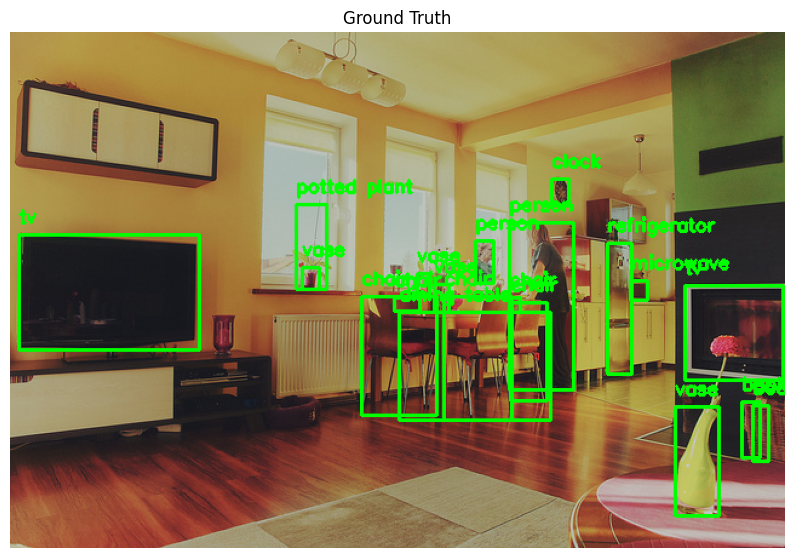

In [21]:
# --- VISUALIZAR GROUND TRUTH ---

# Cargar anotaciones COCO
coco = COCO(ANNOTATIONS_FILE)
gt_boxes, gt_classes = get_ground_truth(coco, IMAGE_ID)

# Visualizar Ground Truth inicial
img_gt = cv2.imread((str(IMAGE_PATH)))
img_gt_viz = draw_boxes(img_gt.copy(), gt_boxes, gt_classes, GREEN) # Verde para GT
cv2.imwrite(os.path.join(OUTPUT_DIR, "ground_truth_only.jpg"), img_gt_viz)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_gt_viz, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Ground Truth")
plt.show()


Una vez visualizada la clasificación real, se realiza la inferencia con los modelos de YOLO n, s, m, l y x. Además, calculan y almacenan las distintas métricas que se obtienen, para poder compararlas.

In [22]:
# 2. Benchmark de modelos YOLO
model_variants = ['n', 's', 'm', 'l', 'x']
results_data = []
all_predictions = {}


for var in model_variants:
    model_name = f'yolov8{var}.pt'
    model = YOLO(model_name)
    results = model(IMAGE_PATH, verbose=False)[0]
  
    pred_boxes = results.boxes.xyxy.cpu().numpy()
    pred_conf = results.boxes.conf.cpu().numpy()
    pred_classes = [results.names[int(c)] for c in results.boxes.cls.cpu().numpy()]
    
    all_predictions[var] = {
        'boxes': pred_boxes,
        'classes': pred_classes,
        'conf': pred_conf
    }
    
    # Calcular métricas simples para esta imagen (IoU > 0.5)
    tp = 0
    matched_gt = set()
    for p_box in pred_boxes:
        for i, g_box in enumerate(gt_boxes):
            if i not in matched_gt and calculate_iou(p_box, g_box) > 0.5:
                tp += 1
                matched_gt.add(i)
                break
    
    precision = tp / len(pred_boxes) if len(pred_boxes) > 0 else 0
    recall = tp / len(gt_boxes) if len(gt_boxes) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    results_data.append({
        "Modelo": model_name,
        "Detecciones": len(pred_boxes),
        "Conf_Media": np.mean(pred_conf) if len(pred_conf) > 0 else 0,
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1, 3),
        "Tiempo_Inferencia(ms)": round(results.speed['inference'], 3)
    })

Ahora se guarda en un DataFrame las métricas obtenidas por los distintos modelos sobre la imagen 139, para poder compararlas más adelante

In [23]:
df = pd.DataFrame(results_data)
print("\nComparativa de modelos YOLO (Imagen 139)")
print(df)

df.to_csv(OUTPUT_DIR / "yolo_model_comparison.csv", index=False)
df.to_latex(OUTPUT_DIR / "yolo_model_comparison.tex", index=False)


Comparativa de modelos YOLO (Imagen 139)
       Modelo  Detecciones  Conf_Media  Precision  Recall  F1-Score  \
0  yolov8n.pt           13    0.483625      0.615     0.4     0.485   
1  yolov8s.pt           16    0.581571      0.750     0.6     0.667   
2  yolov8m.pt           20    0.604530      0.600     0.6     0.600   
3  yolov8l.pt           19    0.620299      0.737     0.7     0.718   
4  yolov8x.pt           19    0.630384      0.737     0.7     0.718   

   Tiempo_Inferencia(ms)  
0                  7.223  
1                  7.186  
2                 10.728  
3                 16.005  
4                 26.345  


Seleccionamos el mejor modelo, considerandolo como aquel que detecte más objetos en la imagen.

In [24]:
# Nos quedamos con el modelo con más detecciones
best_var = df.loc[df['Detecciones'].idxmax()]['Modelo'].split('v8')[1].split('.')[0]
best_preds = all_predictions[best_var]
print(f"\nMejor modelo seleccionado: YOLOv8{best_var}")


Mejor modelo seleccionado: YOLOv8m


Por último generamos la visualización comparativa entre el Ground Truth y las bounding boxes detectadas por el modelo seleccionado. Utilizamos dos tipos de visualización:

1.  **Comparativa Lado a Lado:**
    * **Izquierda (Verde):** Muestra exclusivamente el *Ground Truth* (lo que se espera detectar).
    * **Derecha (Rojo):** Muestra exclusivamente las predicciones del modelo.
    * *Utilidad:* Permite ver limpiarmente qué objetos faltan o sobran sin el "ruido" visual del solapamiento.

2.  **Superposición (Overlay):**
    * Combina ambas cajas en una sola imagen para inspeccionar la precisión del ajuste de las cajas y ver cuánto se desvía la predicción de la realidad.

Imágenes guardadas:
 - c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Primer_Cuatri\Aprendizaje_Automatico\practicas-aprendizaje\profundo\results\comparison_side_by_side_yolov8m.jpg
 - c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Primer_Cuatri\Aprendizaje_Automatico\practicas-aprendizaje\profundo\results\final_comparison_overlay_yolov8m.jpg


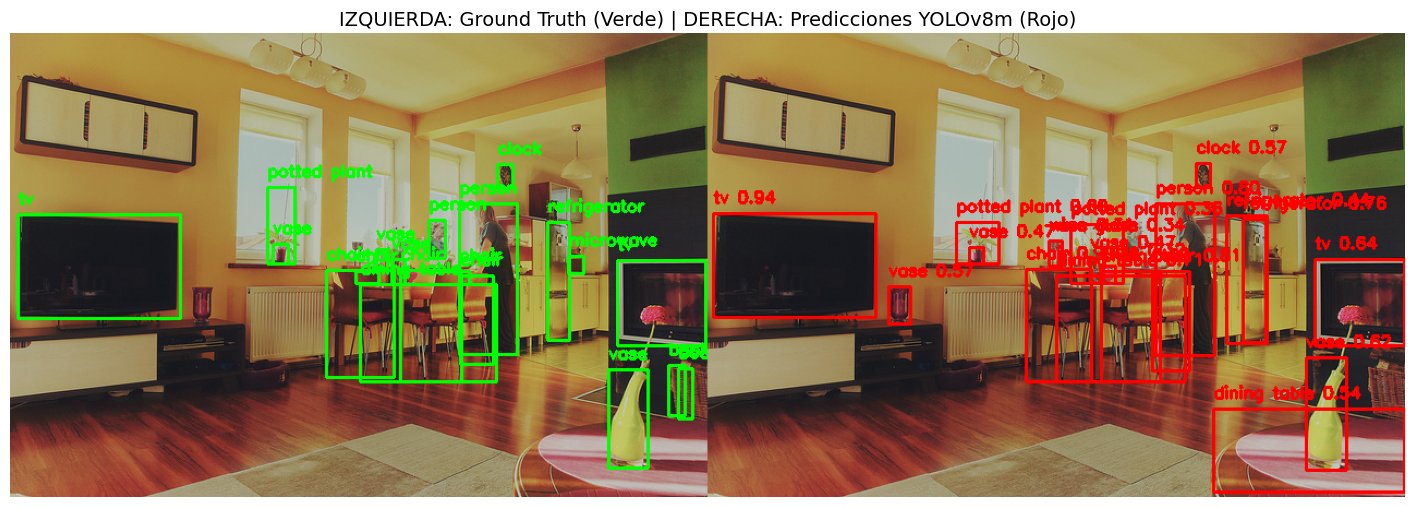

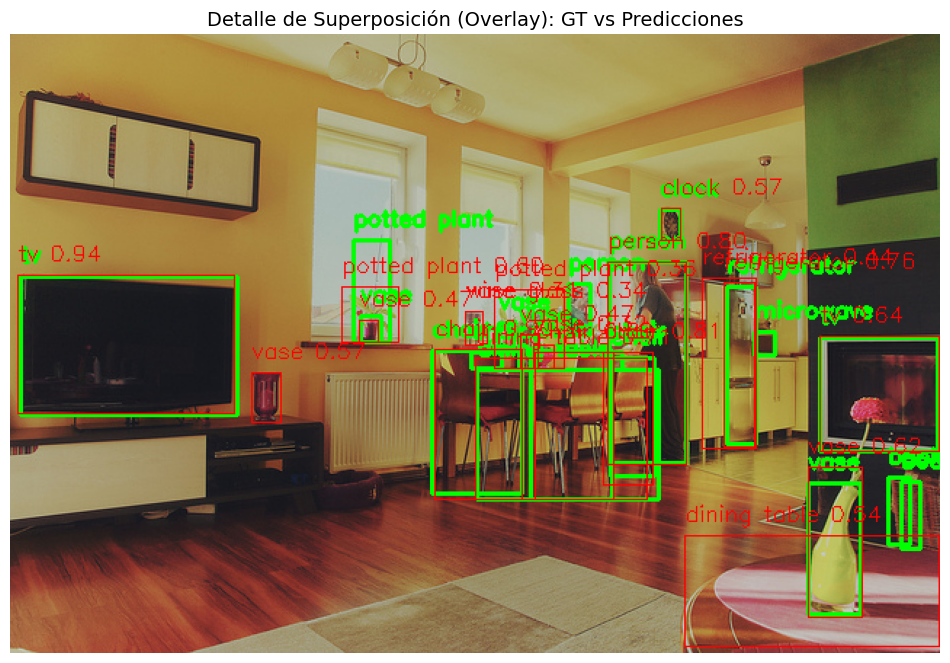

In [ ]:
# Cargar la imagen limpia original
img_base = cv2.imread(str(IMAGE_PATH))

# --- PARTE 1: Generar imágenes individuales ---

# 1.1 Imagen solo con Ground Truth (Verde)
img_gt_only = img_base.copy()
img_gt_only = draw_boxes(img_gt_only, gt_boxes, gt_classes, GREEN, 2)

# 1.2 Imagen solo con Predicciones (Rojo)
img_pred_only = img_base.copy()
# Preparamos las etiquetas incluyendo la confianza
pred_labels = [f"{c} {conf:.2f}" for c, conf in zip(best_preds['classes'], best_preds['conf'])]
img_pred_only = draw_boxes(img_pred_only, best_preds['boxes'], pred_labels, RED, 2)

# --- PARTE 2: Crear Composiciones ---

# 2.1 Composición Lado a Lado (Side-by-Side)
# Usamos np.hstack para pegar las imágenes horizontalmente
side_by_side = np.hstack((img_gt_only, img_pred_only))

# 2.2 Composición Superpuesta (Overlay - Lo que ya tenías)
# Usamos la imagen base y dibujamos AMBOS conjuntos de cajas
img_overlap = img_base.copy()
img_overlap = draw_boxes(img_overlap, gt_boxes, gt_classes, GREEN, 2)            # GT más grueso
img_overlap = draw_boxes(img_overlap, best_preds['boxes'], pred_labels, RED, 1)  # Pred más fino

# --- PARTE 3: Guardar y Mostrar ---

# Rutas de salida
output_sbs_path = os.path.join(OUTPUT_DIR, f"comparison_side_by_side_yolov8{best_var}.jpg")
output_overlap_path = os.path.join(OUTPUT_DIR, f"final_comparison_overlay_yolov8{best_var}.jpg")

# Guardar en disco
cv2.imwrite(output_sbs_path, side_by_side)
cv2.imwrite(output_overlap_path, img_overlap)
print(f"Imágenes guardadas:\n - {output_sbs_path}\n - {output_overlap_path}")

# Visualización con Matplotlib
# Figura 1: Lado a Lado (Hacemos la figura más ancha)
plt.figure(figsize=(18, 8))
plt.imshow(cv2.cvtColor(side_by_side, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"IZQUIERDA: Ground Truth (Verde) | DERECHA: Predicciones YOLOv8{best_var} (Rojo)", fontsize=14)
plt.show()

# Figura 2: Superposición (Zoom centrado)
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img_overlap, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Detalle de Superposición (Overlay): GT vs Predicciones", fontsize=14)
plt.show()

Se puede observar que el modelo ha sido capaz de detectar la mayor parte de los objetos, aunque ha detectado algunos extra que no se encuentran en el Ground Truth. Dicha disparidad con las bounding boxes verdaderas, junto con la falta de precisión en algunas de las detectadas, ha contribuído a que las métricas de rendimiento no sean óptimas, puesto que el modelo presenta unos valores de Confianza, Recall, precisión y F1-score de 0.6.